# Site-adaptation
Satellite measurements: high temporal resolution but limited spatial resolution.

In situ measurements: high accuracy but missing data.

Take the best of both databases to obtain improved spatio-temporal resolution, known as site-adaptation.




## In-situ data

Corresponding solar radiation data (W/m^2) to station: BOTANA - AUT [52055210]. 

From 2006 to 2017 with hourly measurements. 22% missing data.

http://dhime.ideam.gov.co/atencionciudadano/

![IDEAM](https://drive.google.com/uc?export=view&id=1xjlD1ZZfuKa5KMiXtFRkBMuR-4f9pwLr)

## Satellite data

Corresponding satellite data of solar radiation (global, direct, diffuse) (W/m^2), temperature (°C), wind speed (m/s), and Zenith solar angle. With data from 1998 to 2017 with half-hourly measurements and spatial resolution of 4 km^2.

https://maps.nrel.gov/nsrdb-viewer

![NREL](https://drive.google.com/uc?export=view&id=1Q0QG-ODIvrf8fBg5gPi84BDW23Vu7lYy)

[1. Import libreries](#import_librerias)

[2. Load databases](#cargar_imagenes)

[3. Regresion models](#modelos)

[4. Testing best model in test set](#test)

[5. Saving best model](#guardar_modelo)

[6. Testing of the best model](#pruebas)

[7. Applying the model to the entire satellite database](#aplicar_modelo)

[8. Saving improved database](#base_datos_final)

[9. Challenges](#retos)

<a name="import_librerias"></a>
# 1. Import libreries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

<a name="cargar_imagenes"></a>
# 2. Load databases

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML in PV systems/data_IDEAM_NREL.csv')
data.head(24)

,Fecha,GHI_IDEAM,GHI_NSRDB,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
0,2006-01-01 00:00:00,0,0,0,0,0,7,157
1,2006-01-01 01:00:00,0,0,0,0,0,7,153
2,2006-01-01 02:00:00,0,0,0,0,0,6,142
3,2006-01-01 03:00:00,0,0,0,0,0,6,130
4,2006-01-01 04:00:00,0,0,0,0,0,6,117
5,2006-01-01 05:00:00,0,0,0,0,0,6,103
6,2006-01-01 06:00:00,0,21,11,160,0,6,89
7,2006-01-01 07:00:00,513,219,48,695,1,8,76
8,2006-01-01 08:00:00,1633,480,64,901,1,10,62
9,2006-01-01 09:00:00,1290,368,319,78,1,12,49


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81579 entries, 0 to 81578
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Fecha               81579 non-null  object
 1   GHI_IDEAM           81579 non-null  int64 
 2   GHI_NSRDB           81579 non-null  int64 
 3   DHI                 81579 non-null  int64 
 4   DNI                 81579 non-null  int64 
 5   Wind Speed          81579 non-null  int64 
 6   Temperature         81579 non-null  int64 
 7   Solar Zenith Angle  81579 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 5.0+ MB


### 2.1 Comparing in-situ vs satellite data

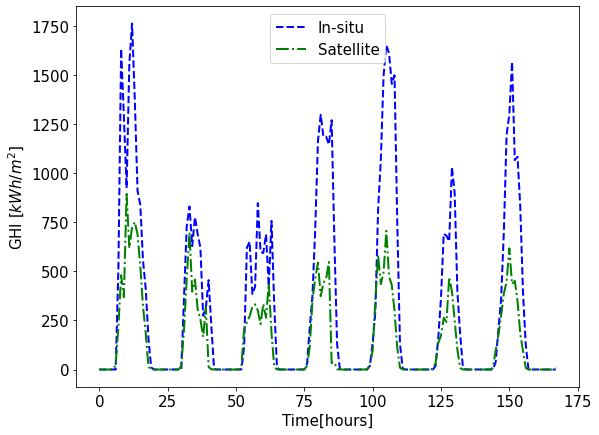

In [ ]:
ghi_ideam = data['GHI_IDEAM'].values
ghi_nsrdb = data['GHI_NSRDB'].values

plt.figure()
plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(ghi_ideam[0:24*7],'--b', label='In-situ', linewidth=2)
plt.plot(ghi_nsrdb[0:24*7],'-.g', label='Satellite', linewidth=2)
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=15)
plt.yticks(size=15)
# plt.savefig('/figure.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
data.corr(method ='pearson')

,GHI_IDEAM,GHI_NSRDB,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
GHI_IDEAM,1.000000,0.808026,0.735807,0.464808,0.260595,0.718470,-0.707808
GHI_NSRDB,0.808026,1.000000,0.832601,0.633091,0.300985,0.741691,-0.737313
DHI,0.735807,0.832601,1.000000,0.168045,0.376760,0.776653,-0.793081
DNI,0.464808,0.633091,0.168045,1.000000,0.052352,0.290528,-0.303762
Wind Speed,0.260595,0.300985,0.376760,0.052352,1.000000,0.421137,-0.526637
Temperature,0.718470,0.741691,0.776653,0.290528,0.421137,1.000000,-0.830112
Solar Zenith Angle,-0.707808,-0.737313,-0.793081,-0.303762,-0.526637,-0.830112,1.000000


<a name="modelos"></a>
# 3. Regresion models

### 3.1 Data mixing

In [ ]:
from sklearn.utils import shuffle
X_ = data[['GHI_NSRDB','DHI','DNI','Wind Speed','Temperature','Solar Zenith Angle']]
y_ = data['GHI_IDEAM']
X, y = shuffle(X_, y_, random_state=42)

In [ ]:
X.head(10)

,GHI_NSRDB,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
8971,0,0,0,1,7,129
15889,0,0,0,0,5,115
45059,177,164,24,3,9,62
65352,132,130,6,4,10,63
62415,1086,144,963,1,13,12
36552,198,186,15,3,10,37
26800,291,270,20,2,14,16
24184,162,150,12,3,15,26
72488,785,225,732,3,13,40
66534,0,0,0,0,6,128


### 3.2 Normalizing and dividing into: training, test and validation sets

In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()

n = len(X)
X_train = X[:round(n*.7)]
X_valid = X[round(n*.7):round(n*.85)]
X_test = X[round(n*.85):]

X_train = X_scaler.fit_transform(X_train)
X_valid = X_scaler.transform(X_valid)
X_test = X_scaler.transform(X_test)


y_scaler = StandardScaler()

y = y.values.reshape(-1, 1)
y_train = y[:round(n*.7)]
y_valid = y[round(n*.7):round(n*.85)]
y_test = y[round(n*.85):]

y_train = y_scaler.fit_transform(y_train).ravel()
y_valid = y_scaler.transform(y_valid).ravel()
y_test = y_scaler.transform(y_test).ravel()

## 3.3 Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lin_reg = LinearRegression()

lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print('Root mean square error: ', round(rmse,2))
print('Mean absolute error: ', round(mae,2))
print('R-Squared: ', round(r2,2))

Root mean square error:  0.56
Mean absolute error:  0.35
R-Squared:  0.69


## 3.4 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100,random_state=42)
forest_reg.fit(X_test, y_test)
y_pred = forest_reg.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print('Root mean square error: ', round(rmse,2))
print('Mean absolute error: ', round(mae,2))
print('R-Squared: ', round(r2,2))

Root mean square error:  0.22
Mean absolute error:  0.11
R-Squared:  0.95


## 3.5 Neural Networks

In [ ]:
from sklearn.neural_network import MLPRegressor

rn_reg = MLPRegressor(hidden_layer_sizes=[10], random_state=42, max_iter=500)
rn_reg.fit(X_train, y_train)
y_pred = rn_reg.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print('Root mean square error: ', round(rmse,2))
print('Mean absolute error: ', round(mae,2))
print('R-Squared: ', round(r2,2))

Root mean square error:  0.54
Mean absolute error:  0.3
R-Squared:  0.71


<a name="test"></a>
# 4 Testing best model in test set

In [ ]:
y_pred = forest_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Root mean square error: ', round(rmse,2))
print('Mean absolute error: ', round(mae,2))
print('R-Squared: ', round(r2,2))

Root mean square error:  0.56
Mean absolute error:  0.29
R-Squared:  0.7


<a name="guardar_modelo"></a>
# 5 Saving best model

In [ ]:
import joblib
joblib.dump(forest_reg, '/content/drive/MyDrive/Colab Notebooks/ML in PV systems/mejor_modelo.pkl')

['/content/drive/MyDrive/Colab Notebooks/ML in PV systems/mejor_modelo.pkl']

<a name="pruebas"></a>
# 6 Testing of the best model

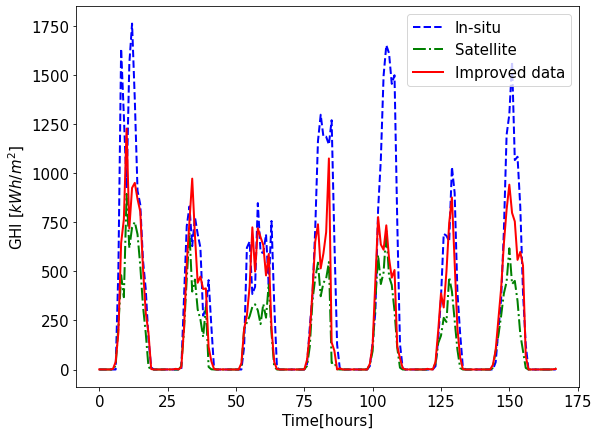

In [ ]:
X_norm = X_scaler.fit_transform(X_)
predictions = forest_reg.predict(X_norm)
y_pred = y_scaler.inverse_transform(predictions)

plt.figure()
plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(ghi_ideam[0:24*7],'--b', label='In-situ', linewidth=2)
plt.plot(ghi_nsrdb[0:24*7],'-.g', label='Satellite', linewidth=2)
plt.plot(y_pred[0:24*7],'r', label='Improved data', linewidth=2)
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=15)
plt.yticks(size=15)
# plt.savefig('/figure.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
data_improved = pd.DataFrame({"GHI_IDEAM": ghi_ideam, "GHI_NSRDB": ghi_nsrdb, "GHI_improved": y_pred})
data_improved.corr(method ='pearson')

,GHI_IDEAM,GHI_NSRDB,GHI_improved
GHI_IDEAM,1.000000,0.808026,0.854503
GHI_NSRDB,0.808026,1.000000,0.921712
GHI_improved,0.854503,0.921712,1.000000


<a name="aplicar_modelo"></a>
# 7 Applying the model to the entire satellite database

In [ ]:
GHI_NREL = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML in PV systems/GHI_NREL.csv')

scaler = StandardScaler()
GHI_NREL_norm = X_scaler.fit_transform(GHI_NREL)

GHI_impr = forest_reg.predict(GHI_NREL_norm)
GHI_impr = y_scaler.inverse_transform(GHI_impr)


<a name="base_datos_final"></a>
# 8 Saving improved database

In [ ]:
GHI_impr = pd.DataFrame(np.round(GHI_impr))
GHI_impr.to_csv('/content/drive/MyDrive/Colab Notebooks/ML in PV systems/GHI_impr.csv', index=False)

<a name="retos"></a>
# 9. Challenges

1. Test other regression methods such as Support Vector Regression, AdaBoost.
2. Implement cross-validation.

Hint:

from sklearn.svm import SVR

from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score

